In [1]:
import os

from dotenv import load_dotenv

# Load environment variables
load_dotenv()

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["ANTHROPIC_API_KEY"] = os.getenv("ANTHROPIC_API_KEY")

In [2]:
from bs4 import BeautifulSoup as Soup
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader

# LCEL docs
url = "https://python.langchain.com/v0.2/docs/concepts/#langchain-expression-language-lcel"
loader = RecursiveUrlLoader(
    url=url, max_depth=20, extractor=lambda x: Soup(x, "html.parser").text
)
docs = loader.load()

# Sort the list based on the URLs and get the text
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))
concatenated_content = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)

In [3]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI

### OpenAI

# Grader prompt
code_gen_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are a coding assistant with expertise in LCEL, LangChain expression language.
                Here is a full set of LCEL documentation:
                ------- 
                {context}
                ------- 
                Answer the user question based on the above provided documentation. Ensure any code you provide can be executed 
                with all required imports and variables defined. Structure your answer with a description of the code solution.
                Then list the imports. And finally list the functioning code block. Here is the user question:""",
        ),
        ("placeholder", "{messages}"),
    ]
)


# Data model
class code(BaseModel):
    """Code output"""

    prefix: str = Field(description="Description of the problem and approach")
    imports: str = Field(description="Code block import statements")
    code: str = Field(description="Code block not including import statements")
    description = "Schema for code solutions to questions about LCEL."


llm = ChatOpenAI(temperature=0)
code_gen_chain = code_gen_prompt | llm.with_structured_output(code)
question = "How do I build a RAG chain in LCEL?"
solution = code_gen_chain.invoke(
    {"context": concatenated_content, "messages": [("user", question)]}
)
solution

code(prefix='# To build a RAG chain in LCEL, you need to define the components of the chain such as retrievers, tools, and chat models. Then, you can use the LangChain Expression Language (LCEL) to chain these components together to create a retrieval augmented generation (RAG) system.\n\n# Define the components of the RAG chain\nretriever = ...\ntool = ...\nchat_model = ...\n\n# Chain the components together using LCEL\nchain = {\n    "retriever": retriever,\n    "tool": tool,\n    "chat_model": chat_model\n}\n\n# Execute the RAG chain\noutput = chain.invoke(input_data)\n', imports='from langchain_core import ChatModel, Retriever, Tool', code='# Define the components of the RAG chain\nretriever = Retriever(...)\ntool = Tool(...)\nchat_model = ChatModel(...)\n\n# Chain the components together using LCEL\nchain = {\n    "retriever": retriever,\n    "tool": tool,\n    "chat_model": chat_model\n}\n\n# Execute the RAG chain\noutput = chain.invoke(input_data)\n', description='Schema for cod

In [4]:
from typing import List, TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        error : Binary flag for control flow to indicate whether test error was tripped
        messages : With user question, error messages, reasoning
        generation : Code solution
        iterations : Number of tries
    """

    error: str
    messages: List
    generation: str
    iterations: int

In [5]:
from langchain_core.pydantic_v1 import BaseModel, Field

### Parameter

# Max tries
max_iterations = 3
# Reflect
# flag = 'reflect'
flag = "do not reflect"

### Nodes


def generate(state: GraphState):
    """
    Generate a code solution

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation
    """

    print("---GENERATING CODE SOLUTION---")

    # State
    messages = state["messages"]
    iterations = state["iterations"]
    error = state["error"]

    # We have been routed back to generation with an error
    if error == "yes":
        messages += [
            (
                "user",
                "Now, try again. Invoke the code tool to structure the output with a prefix, imports, and code block:",
            )
        ]

    # Solution
    code_solution = code_gen_chain.invoke(
        {"context": concatenated_content, "messages": messages}
    )
    messages += [
        (
            "assistant",
            f"{code_solution.prefix} \n Imports: {code_solution.imports} \n Code: {code_solution.code}",
        )
    ]

    # Increment
    iterations = iterations + 1
    return {"generation": code_solution, "messages": messages, "iterations": iterations}


def code_check(state: GraphState):
    """
    Check code

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, error
    """

    print("---CHECKING CODE---")

    # State
    messages = state["messages"]
    code_solution = state["generation"]
    iterations = state["iterations"]

    # Get solution components
    imports = code_solution.imports
    code = code_solution.code

    # Check imports
    try:
        exec(imports)
    except Exception as e:
        print("---CODE IMPORT CHECK: FAILED---")
        error_message = [("user", f"Your solution failed the import test: {e}")]
        messages += error_message
        return {
            "generation": code_solution,
            "messages": messages,
            "iterations": iterations,
            "error": "yes",
        }

    # Check execution
    try:
        exec(imports + "\n" + code)
    except Exception as e:
        print("---CODE BLOCK CHECK: FAILED---")
        error_message = [("user", f"Your solution failed the code execution test: {e}")]
        messages += error_message
        return {
            "generation": code_solution,
            "messages": messages,
            "iterations": iterations,
            "error": "yes",
        }

    # No errors
    print("---NO CODE TEST FAILURES---")
    return {
        "generation": code_solution,
        "messages": messages,
        "iterations": iterations,
        "error": "no",
    }


def reflect(state: GraphState):
    """
    Reflect on errors

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation
    """

    print("---GENERATING CODE SOLUTION---")

    # State
    messages = state["messages"]
    iterations = state["iterations"]
    code_solution = state["generation"]

    # Prompt reflection

    # Add reflection
    reflections = code_gen_chain.invoke(
        {"context": concatenated_content, "messages": messages}
    )
    messages += [("assistant", f"Here are reflections on the error: {reflections}")]
    return {"generation": code_solution, "messages": messages, "iterations": iterations}


### Edges


def decide_to_finish(state: GraphState):
    """
    Determines whether to finish.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """
    error = state["error"]
    iterations = state["iterations"]

    if error == "no" or iterations == max_iterations:
        print("---DECISION: FINISH---")
        return "end"
    else:
        print("---DECISION: RE-TRY SOLUTION---")
        if flag == "reflect":
            return "reflect"
        else:
            return "generate"

In [6]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("generate", generate)  # generation solution
workflow.add_node("check_code", code_check)  # check code
workflow.add_node("reflect", reflect)  # reflect

# Build graph
workflow.add_edge(START, "generate")
workflow.add_edge("generate", "check_code")
workflow.add_conditional_edges(
    "check_code",
    decide_to_finish,
    {
        "end": END,
        "reflect": "reflect",
        "generate": "generate",
    },
)
workflow.add_edge("reflect", "generate")
app = workflow.compile()

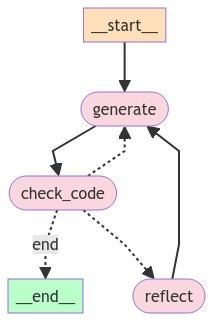

In [8]:
from IPython.display import Image, display


display(Image(app.get_graph().draw_mermaid_png()))

In [10]:
question = "How can I directly pass a string to a runnable and use it to construct the input needed for my prompt?"
app.invoke({"messages": [("user", question)], "iterations": 0})

---GENERATING CODE SOLUTION---
---CHECKING CODE---
---NO CODE TEST FAILURES---
---DECISION: FINISH---


{'error': 'no',
 'messages': [('user',
   'How can I directly pass a string to a runnable and use it to construct the input needed for my prompt?'),
  ('assistant',
   'To directly pass a string to a runnable and use it to construct the input needed for a prompt, you can create a ChatPromptTemplate with the string as the input and then invoke the prompt with the string. \n Imports: from langchain_core.prompts import ChatPromptTemplate \n Code: # Create a ChatPromptTemplate with the string\nprompt = ChatPromptTemplate.from_template("Your string goes here")\n\n# Invoke the prompt with the string\nprompt.invoke({})')],
 'generation': code(prefix='To directly pass a string to a runnable and use it to construct the input needed for a prompt, you can create a ChatPromptTemplate with the string as the input and then invoke the prompt with the string.', imports='from langchain_core.prompts import ChatPromptTemplate', code='# Create a ChatPromptTemplate with the string\nprompt = ChatPromptTempl

Eval


In [11]:
import langsmith

client = langsmith.Client()

In [20]:
# Clone the dataset to your tenant to use it
public_dataset = (
    "https://smith.langchain.com/public/326674a6-62bd-462d-88ae-eea49d503f9d/d"
)
client.clone_public_dataset(public_dataset, dataset_name="test-LCEL-code-gen")

In [21]:
from langsmith.schemas import Example, Run


def check_import(run: Run, example: Example) -> dict:
    imports = run.outputs.get("imports")
    try:
        exec(imports)
        return {"key": "import_check", "score": 1}
    except Exception:
        return {"key": "import_check", "score": 0}


def check_execution(run: Run, example: Example) -> dict:
    imports = run.outputs.get("imports")
    code = run.outputs.get("code")
    try:
        exec(imports + "\n" + code)
        return {"key": "code_execution_check", "score": 1}
    except Exception:
        return {"key": "code_execution_check", "score": 0}

In [22]:
def predict_base_case(example: dict):
    """Context stuffing"""
    solution = code_gen_chain.invoke(
        {"context": concatenated_content, "messages": [("user", example["question"])]}
    )
    solution_structured = code_gen_chain.invoke([("code", solution)])
    return {"imports": solution_structured.imports, "code": solution_structured.code}


def predict_langgraph(example: dict):
    """LangGraph"""
    graph = app.invoke({"messages": [("user", example["question"])], "iterations": 0})
    solution = graph["generation"]
    return {"imports": solution.imports, "code": solution.code}

In [23]:
from langsmith.evaluation import evaluate

# Evaluator
code_evalulator = [check_import, check_execution]

# Dataset
dataset_name = "test-LCEL-code-gen"

In [24]:
# Run base case
experiment_results_ = evaluate(
    predict_base_case,
    data=dataset_name,
    evaluators=code_evalulator,
    experiment_prefix=f"test-without-langgraph-{llm}",
    max_concurrency=2,
    metadata={
        "llm": llm,
    },
)

View the evaluation results for experiment: 'test-without-langgraph-client=<openai.resources.chat.completions.Completions object at 0x11b25f050> async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x11b277150> temperature=0.0 openai_api_key=SecretStr('**********') openai_proxy=''-e4391c19' at:
https://smith.langchain.com/o/0feae8f0-454e-5e76-8ccc-bd3eb6e53859/datasets/081189c4-216b-49f6-ba9f-c4e362a4dfe0/compare?selectedSessions=0f3aec20-4ced-4308-b091-09d343cdde55




0it [00:00, ?it/s]

Error running target function: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-g7OThWZZWSYLozKLfRKTmdst on tokens per min (TPM): Limit 60000, Used 53743, Requested 17636. Please try again in 11.379s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}
Error running target function: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-g7OThWZZWSYLozKLfRKTmdst on tokens per min (TPM): Limit 60000, Used 56323, Requested 17656. Please try again in 13.979s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}
Error running target function: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-g7OThWZZWSYLozKLfRKTmdst on tokens per min (TPM): Limit 60000, Used 56812, Requested 17645. Please 

In [25]:
# Run with langgraph
experiment_results = evaluate(
    predict_langgraph,
    data=dataset_name,
    evaluators=code_evalulator,
    experiment_prefix=f"test-with-langgraph-{llm}-{flag}",
    max_concurrency=2,
    metadata={
        "llm": llm,
        "feedback": flag,
    },
)

View the evaluation results for experiment: 'test-with-langgraph-client=<openai.resources.chat.completions.Completions object at 0x11b25f050> async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x11b277150> temperature=0.0 openai_api_key=SecretStr('**********') openai_proxy=''-do not reflect-785738f9' at:
https://smith.langchain.com/o/0feae8f0-454e-5e76-8ccc-bd3eb6e53859/datasets/081189c4-216b-49f6-ba9f-c4e362a4dfe0/compare?selectedSessions=a864fb85-5e6a-4872-be0d-af7e61afbf8f




0it [00:00, ?it/s]

---GENERATING CODE SOLUTION---
---GENERATING CODE SOLUTION---
---CHECKING CODE---
---CODE IMPORT CHECK: FAILED---
---DECISION: RE-TRY SOLUTION---
---GENERATING CODE SOLUTION---
---CHECKING CODE---
---CODE IMPORT CHECK: FAILED---
---DECISION: RE-TRY SOLUTION---
---GENERATING CODE SOLUTION---
---CHECKING CODE---
---CODE IMPORT CHECK: FAILED---
---DECISION: RE-TRY SOLUTION---
---GENERATING CODE SOLUTION---
---CHECKING CODE---
---CODE IMPORT CHECK: FAILED---
---DECISION: FINISH---
---GENERATING CODE SOLUTION---


Error running target function: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-g7OThWZZWSYLozKLfRKTmdst on tokens per min (TPM): Limit 60000, Used 52151, Requested 17881. Please try again in 10.032s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}


---GENERATING CODE SOLUTION---
---CHECKING CODE---
---CODE IMPORT CHECK: FAILED---
---DECISION: RE-TRY SOLUTION---
---GENERATING CODE SOLUTION---


Error running target function: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-g7OThWZZWSYLozKLfRKTmdst on tokens per min (TPM): Limit 60000, Used 56460, Requested 17637. Please try again in 14.097s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}


---GENERATING CODE SOLUTION---
---CHECKING CODE---
---CODE IMPORT CHECK: FAILED---
---DECISION: RE-TRY SOLUTION---
---GENERATING CODE SOLUTION---
---CHECKING CODE---
---CODE IMPORT CHECK: FAILED---
---DECISION: FINISH---
---GENERATING CODE SOLUTION---


Error running target function: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-g7OThWZZWSYLozKLfRKTmdst on tokens per min (TPM): Limit 60000, Used 56157, Requested 17643. Please try again in 13.8s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}


---GENERATING CODE SOLUTION---
---CHECKING CODE---
---CODE IMPORT CHECK: FAILED---
---DECISION: RE-TRY SOLUTION---
---GENERATING CODE SOLUTION---
---CHECKING CODE---
---CODE IMPORT CHECK: FAILED---
---DECISION: RE-TRY SOLUTION---
---GENERATING CODE SOLUTION---


Error running target function: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-g7OThWZZWSYLozKLfRKTmdst on tokens per min (TPM): Limit 60000, Used 57320, Requested 17632. Please try again in 14.952s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}


---GENERATING CODE SOLUTION---
---CHECKING CODE---
---CODE BLOCK CHECK: FAILED---
---DECISION: FINISH---
---GENERATING CODE SOLUTION---
---CHECKING CODE---
---CODE IMPORT CHECK: FAILED---
---DECISION: RE-TRY SOLUTION---
---GENERATING CODE SOLUTION---
---CHECKING CODE---
---CODE IMPORT CHECK: FAILED---
---DECISION: RE-TRY SOLUTION---
---GENERATING CODE SOLUTION---


Error running target function: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-g7OThWZZWSYLozKLfRKTmdst on tokens per min (TPM): Limit 60000, Used 52751, Requested 17656. Please try again in 10.407s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}


---GENERATING CODE SOLUTION---
---CHECKING CODE---
---NO CODE TEST FAILURES---
---DECISION: FINISH---
---GENERATING CODE SOLUTION---
---CHECKING CODE---
---NO CODE TEST FAILURES---
---DECISION: FINISH---
---GENERATING CODE SOLUTION---


Error running target function: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-g7OThWZZWSYLozKLfRKTmdst on tokens per min (TPM): Limit 60000, Used 52447, Requested 17801. Please try again in 10.248s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}


---GENERATING CODE SOLUTION---
---CHECKING CODE---
---CODE BLOCK CHECK: FAILED---
---DECISION: RE-TRY SOLUTION---
---GENERATING CODE SOLUTION---
---CHECKING CODE---
---CODE BLOCK CHECK: FAILED---
---DECISION: RE-TRY SOLUTION---
---GENERATING CODE SOLUTION---


Error running target function: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-g7OThWZZWSYLozKLfRKTmdst on tokens per min (TPM): Limit 60000, Used 52404, Requested 17634. Please try again in 10.038s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}


---GENERATING CODE SOLUTION---
---CHECKING CODE---
---CODE BLOCK CHECK: FAILED---
---DECISION: RE-TRY SOLUTION---
---GENERATING CODE SOLUTION---
---CHECKING CODE---
---CODE BLOCK CHECK: FAILED---
---DECISION: RE-TRY SOLUTION---
---GENERATING CODE SOLUTION---


Error running target function: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-g7OThWZZWSYLozKLfRKTmdst on tokens per min (TPM): Limit 60000, Used 52215, Requested 17979. Please try again in 10.194s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}


---GENERATING CODE SOLUTION---
---CHECKING CODE---
---CODE BLOCK CHECK: FAILED---
---DECISION: FINISH---
---GENERATING CODE SOLUTION---


Error running target function: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-g7OThWZZWSYLozKLfRKTmdst on tokens per min (TPM): Limit 60000, Used 55975, Requested 17657. Please try again in 13.632s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}


---GENERATING CODE SOLUTION---
---CHECKING CODE---
---CODE IMPORT CHECK: FAILED---
---DECISION: RE-TRY SOLUTION---
---GENERATING CODE SOLUTION---
---CHECKING CODE---
---CODE IMPORT CHECK: FAILED---
---DECISION: RE-TRY SOLUTION---
---GENERATING CODE SOLUTION---


Error running target function: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-g7OThWZZWSYLozKLfRKTmdst on tokens per min (TPM): Limit 60000, Used 56540, Requested 17945. Please try again in 14.485s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}


---GENERATING CODE SOLUTION---
---CHECKING CODE---
---CODE IMPORT CHECK: FAILED---
---DECISION: RE-TRY SOLUTION---
---GENERATING CODE SOLUTION---
---CHECKING CODE---
---CODE IMPORT CHECK: FAILED---
---DECISION: FINISH---
---GENERATING CODE SOLUTION---
---CHECKING CODE---
---CODE BLOCK CHECK: FAILED---
---DECISION: RE-TRY SOLUTION---
---GENERATING CODE SOLUTION---


Error running target function: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-g7OThWZZWSYLozKLfRKTmdst on tokens per min (TPM): Limit 60000, Used 52698, Requested 17638. Please try again in 10.336s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}


---GENERATING CODE SOLUTION---
---CHECKING CODE---
---CODE BLOCK CHECK: FAILED---
---DECISION: RE-TRY SOLUTION---
---GENERATING CODE SOLUTION---
---CHECKING CODE---
---NO CODE TEST FAILURES---
---DECISION: FINISH---


Error running target function: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-g7OThWZZWSYLozKLfRKTmdst on tokens per min (TPM): Limit 60000, Used 53040, Requested 17846. Please try again in 10.886s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}
